In [7]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [8]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 arm12qd.18_0h 04 arm12qd.18_2h 05 arm12qd.34_0h
1 0.9373545 23.69756        0.9659363         21.90720               NA
2 1.0046317 21.06340        1.0139595         23.47956               NA
3 1.0619138 21.95788        1.0210121         23.15631               NA
4 0.9416960 20.82147               NA               NA        0.9862327
5 0.8487040 21.55574               NA               NA        1.0000000
6 1.2512181 21.25897               NA               NA        1.0139595
  06 arm12qd.34_2h 07 flg22_0h 08 flg22_2h   Group
1               NA   1.0139595    73.00888 Trial01
2               NA   1.0069556    72.50457 Trial01
3               NA   0.9794203    78.79324 Trial01
4         25.99208   0.9749049    85.03589 Trial01
5         25.63424   1.1044540    84.44851 Trial01
6         25.10669   0.9287314    92.41147 Trial01
# A tibble: 6 × 3
  ind              Group   values
  <chr>            <chr>    <dbl>
1 01 wt_0h         Trial01  0.937
2 02 wt_2h         

# A tibble: 6 × 3
  Treatment Trial   VALUE
  <chr>     <chr>   <dbl>
1 01 wt_0h  Trial01 0.937
2 01 wt_0h  Trial01 1.00 
3 01 wt_0h  Trial01 1.06 
4 01 wt_0h  Trial01 0.942
5 01 wt_0h  Trial01 0.849
6 01 wt_0h  Trial01 1.25 


[1] 36 67

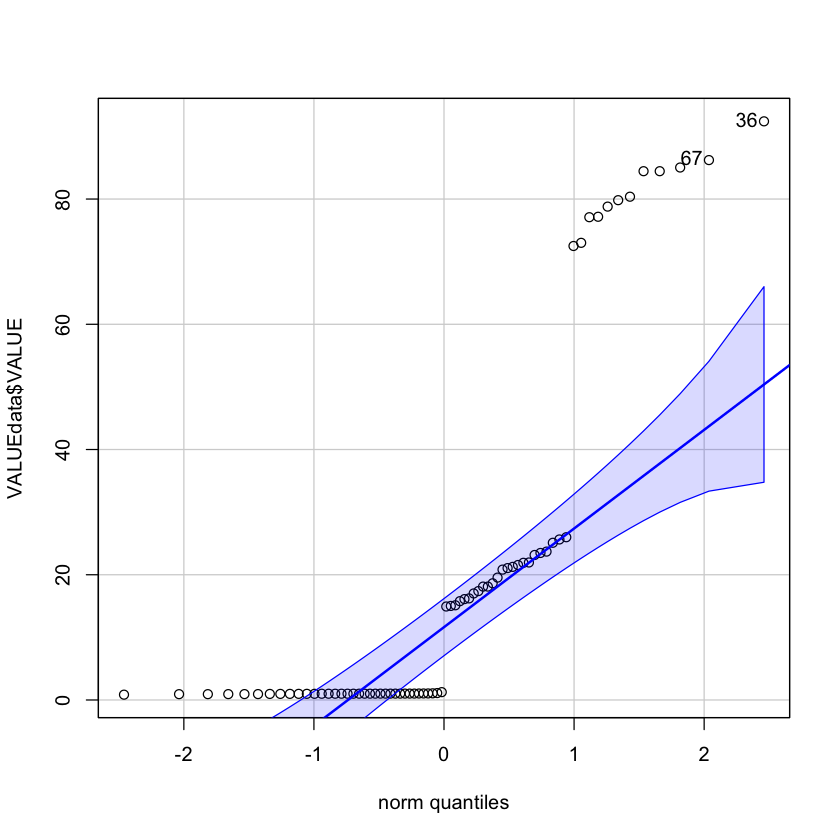

In [9]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   379.3    402.1   -179.7    359.3       62 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2244 -0.2946  0.1041  0.2901  3.7086 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept) 0.8491   0.9214  
 Residual             8.2444   2.8713  
Number of obs: 72, groups:  Trial, 2

Fixed effects:
                           Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)                1.004100   1.054309  8.239229   0.952    0.368    
Treatment02 wt_2h         18.649275   1.172209 70.000002  15.910   <2e-16 ***
Treatment03 arm12qd.18_0h -0.003946   1.435657 70.000002  -0.003    0.998    
Treatment04 arm12qd.18_2h 18.643742   1.435657 70.000002  12.986   <2e-16 ***
Treatment05 arm12qd.34_0h -0.004066   1.435657 70.000002  -0.00

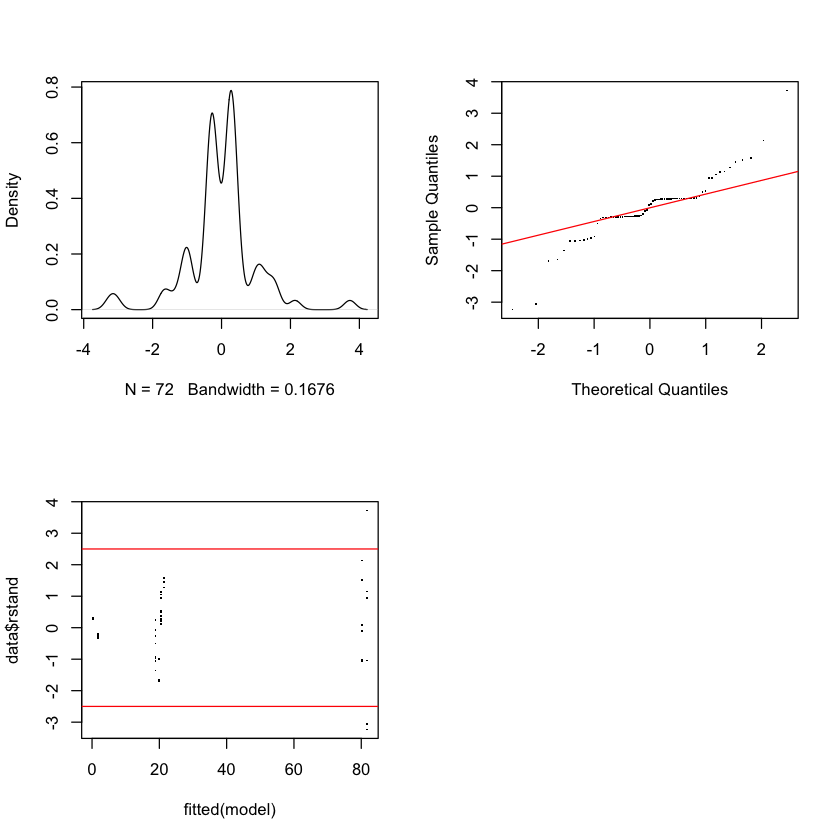

In [10]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [11]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF       F value     
 Min.   :57542   Min.   :8220   Min.   :7   Min.   :70   Min.   :997.1  
 1st Qu.:57542   1st Qu.:8220   1st Qu.:7   1st Qu.:70   1st Qu.:997.1  
 Median :57542   Median :8220   Median :7   Median :70   Median :997.1  
 Mean   :57542   Mean   :8220   Mean   :7   Mean   :70   Mean   :997.1  
 3rd Qu.:57542   3rd Qu.:8220   3rd Qu.:7   3rd Qu.:70   3rd Qu.:997.1  
 Max.   :57542   Max.   :8220   Max.   :7   Max.   :70   Max.   :997.1  
     Pr(>F)         
 Min.   :1.879e-67  
 1st Qu.:1.879e-67  
 Median :1.879e-67  
 Mean   :1.879e-67  
 3rd Qu.:1.879e-67  
 Max.   :1.879e-67  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                           Estimate Std. Error z value Pr(>|z|)
02 wt_2h - 01 wt_0h == 0                  1.865e+0